In [10]:
# ! pip install streamlit
! pip install plotly

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
from datetime import timedelta
import plotly.express as px

pd.set_option('display.max_columns', 40)
# display max rows 75
pd.set_option('display.max_rows', 75)

Pour reprendre en route, possible de récupérer directement la verion du dataset depuis les fichiers parquets

In [54]:
# df_book = pd.read_parquet('df_book.parquet')
df_book_updated = pd.read_parquet('df_book_updated.parquet')
df_book_streamlit = pd.read_parquet("df_book_streamlit.parquet")
df_stat = pd.read_parquet('../data_sources_from_python/stats_lecture.parquet')


# fichiers source
Attention aux noms des tables et des variables.
Attention aux noms des fichiers générés

* df_book --> df_book_updated --> df_book_streamlit
* df_stat

In [2]:
df_book = pd.read_parquet('../data_sources_from_python/df_book.parquet')
df_book.to_excel("df_book.xlsx", index=False)
df_book.head(5)

,id,Titre,Auteurs,notes,Date dernière ouverture,page,Série,Langue,total_read_time,total Nbr de pages lues,oeuvre,id long,Auteurs courts,format,First published date,categorie
0,2,Le crime de l'Orient-Express,"Christie, Agatha",0,2023-11-27,349,l'Orient #1,fr,13191,330,"Le crime de l'Orient-Express - Christie, Agatha",00002,Christie Agatha,ebook,1934,fiction/SF
1,3,Let's Get Together,Isaac Asimov,0,2023-11-27,68,N/A,en,388,8,Let's Get Together - Isaac Asimov,00003,Isaac Asimov,ebook,1957,fiction/SF
2,4,La nuit des temps,"Barjavel,René",0,2024-01-08,449,N/A,und,12240,289,"La nuit des temps - Barjavel,René",00004,Barjavel René,ebook,1968,fiction/SF
3,5,"Chasseur, cueilleur, parent: les cultures ance...",Michaeleen Doucleff,0,2024-01-09,675,N/A,fr,18029,418,"Chasseur, cueilleur, parent: les cultures ance...",00005,Michaeleen Doucleff,ebook,2021,non-fiction/parenting
4,11,La faune de l'espace,"Van Vogt,Alfred E",0,2024-01-08,809,N/A,fr,22,2,"La faune de l'espace - Van Vogt,Alfred E",00011,Van Vogt,ebook,1950,fiction/SF


In [29]:
df_stat = pd.read_parquet('../data_sources_from_python/stats_lecture.parquet')
df_stat.to_excel("df_stat.xlsx", index=False)
df_stat.columns

Index(['id_book', 'page', 'heure de début',
       'Temps passé sur la page en seconde', 'total_pages', 'id_long',
       'Temps de lecture en minute', 'Temps de lecture en heure',
       'date lecture', 'Heure de début de lecture', 'Heure',
       'Heure en décimal', 'Jour Précédent', 'Est Consécutif',
       'date de fin de lecture'],
      dtype='object')

In [43]:
df_stat.head(10)

,id_book,page,heure de début,Temps passé sur la page en seconde,total_pages,id_long,Temps de lecture en minute,Temps de lecture en heure,date lecture,Heure de début de lecture,Heure,Heure en décimal,Jour Précédent,Est Consécutif,date de fin de lecture
0,1,1,2023-11-21 20:26:32,14,8,00001,0.233333,0.003889,2023-11-21,20,20,20.433333,2023-11-20,False,2023-11-21
1,1,6,2023-11-21 20:26:46,21,8,00001,0.350000,0.005833,2023-11-21,20,20,20.433333,2023-11-20,True,2023-11-21
2,1,7,2023-11-21 20:27:10,5,8,00001,0.083333,0.001389,2023-11-21,20,20,20.450000,2023-11-20,True,2023-11-21
3,1,8,2023-11-21 20:27:15,14,8,00001,0.233333,0.003889,2023-11-21,20,20,20.450000,2023-11-20,True,2023-11-21
4,2,5,2023-11-21 20:41:41,120,346,00002,2.000000,0.033333,2023-11-21,20,20,20.683333,2023-11-20,True,2023-11-27
5,2,5,2023-11-21 20:47:36,120,349,00002,2.000000,0.033333,2023-11-21,20,20,20.783333,2023-11-20,True,2023-11-27
6,2,5,2023-11-21 20:50:53,75,349,00002,1.250000,0.020833,2023-11-21,20,20,20.833333,2023-11-20,True,2023-11-27
7,2,5,2023-11-21 20:52:32,23,349,00002,0.383333,0.006389,2023-11-21,20,20,20.866667,2023-11-20,True,2023-11-27
8,2,6,2023-11-21 21:00:12,7,349,00002,0.116667,0.001944,2023-11-21,21,21,21.000000,2023-11-20,True,2023-11-27
9,2,7,2023-11-21 21:00:19,7,349,00002,0.116667,0.001944,2023-11-21,21,21,21.000000,2023-11-20,True,2023-11-27


# visuel 1 : table avec la liste des livres lus dans l'année. --> DONE
## step 1 : easy
* trié du plus récent au plus ancien 
* uniquement les livres lus en entier

## step 2 : 
* Récupérer le nombre de jour de lecture pour chaque livre 
* calculer le nombre de pages lues par jour de lecture
* calculer le nombre d'heures de lecture par jour de lecture
* calculer la vitesse de lecture : page /min

In [8]:
# Ignorer les avertissements
warnings.filterwarnings('ignore')

# Assurez-vous que la colonne "date lecture" est bien de type datetime
df_stat['date lecture'] = pd.to_datetime(df_stat['date lecture'])

# Grouper df_stat par 'id_book' et calculer les valeurs souhaitées
df_stat_grouped = df_stat.groupby('id_book').agg({
    'Temps passé sur la page en seconde': 'sum',
    'date lecture': ['nunique', 'min', 'max']
}).reset_index()

# Aplatir les colonnes multi-niveaux résultantes après l'aggrégation
df_stat_grouped.columns = ['id', 'total_temps_sur_page_seconde', 'nb_dates_lecture_distinctes', 'start_date', 'end_date']

# Calculer la durée de l'intervalle de lecture
df_stat_grouped['intervalle_lecture_en_jour'] = 1 +(df_stat_grouped['end_date'] - df_stat_grouped['start_date']).dt.days

# Fusionner les résultats avec df_book
df_book_updated = df_book.merge(df_stat_grouped, how='left', on='id')

# Remplacer les valeurs NaN pour les colonnes nouvellement calculées, si nécessaire
df_book_updated['total_temps_sur_page_seconde'].fillna(0, inplace=True)
df_book_updated['nb_dates_lecture_distinctes'].fillna(0, inplace=True)
df_book_updated['intervalle_lecture_en_jour'].fillna(0, inplace=True)

# nombre de page lue par jour de lecture (total Nbr de pages lues / nb_dates_lecture_distinctes), arrondi à 2 chiffres après la virgule

df_book_updated['nb_pages_lues_par_jour_de_lecture'] = (df_book_updated['total Nbr de pages lues'] / df_book_updated['nb_dates_lecture_distinctes']).round(1)

# heure de lecure par jour de lecture
df_book_updated['heure_lecture_par_jour_de_lecture'] = (df_book_updated['total_temps_sur_page_seconde'] / df_book_updated['nb_dates_lecture_distinctes'] / 3600).round(2)
df_book_updated['minutes_lecture_par_jour_de_lecture'] = (df_book_updated['total_temps_sur_page_seconde'] / df_book_updated['nb_dates_lecture_distinctes'] / 60).round(1)

# Remplacer les valeurs NaN dans la colonne 'heure_lecture_par_jour_de_lecture' par 0
df_book_updated['heure_lecture_par_jour_de_lecture'].fillna(0, inplace=True)

# Convertir les heures de lecture en durée formatée (HH:MM:SS)
df_book_updated['temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss)'] = df_book_updated['heure_lecture_par_jour_de_lecture'].apply(
    lambda x: str(timedelta(hours=x))
)

# passer temps_lecture_par_jour_de_lecture_formatee en hh:mm
df_book_updated['temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss)'] = df_book_updated['temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss)'].str[:4]

df_book_updated["total_temps_de_lecture_(hh:mm:ss)"] = df_book_updated["total_temps_sur_page_seconde"].apply(
    lambda x: str(timedelta(seconds=x))
)

# drop les lignes ou "nb_dates_lecture_distinctes" est égale à 0
df_book_updated = df_book_updated[df_book_updated['nb_dates_lecture_distinctes'] != 0]

# order by "Date dernière ouverture"
df_book_updated = df_book_updated.sort_values(by='Date dernière ouverture', ascending=False)

# ajoute une colonne "pourcent_lu" : "total Nbr de pages lues du livre" / "page"
df_book_updated['pourcent_lu'] = (df_book_updated['total Nbr de pages lues'] / df_book_updated['page'] * 100).round(0)

df_book_updated["temps passé sur le livre en minute"] = (df_book_updated["total_temps_sur_page_seconde"] / 60).round(2)
df_book_updated["temps passé sur le livre en heure"] = (df_book_updated["total_temps_sur_page_seconde"] / 3600).round(2)

# rename colonnes page en page total livre
df_book_updated.rename(columns={
    'page': 'total Nbr de pages du livre',
    "total_temps_sur_page_seconde":"temps passé sur le livre en seconde"

    }, inplace=True)


# diviser la colonne série en 2 : série et numéro de série, en utilisant "#" comme séparateur
df_book_updated[['série', 'numéro_série']] = df_book_updated['Série'].str.split('#', expand=True)

# changer le format de start_date et end_date en yyyy-mm-dd
df_book_updated['start_date'] = df_book_updated['start_date'].dt.strftime('%Y-%m-%d')
df_book_updated['end_date'] = df_book_updated['end_date'].dt.strftime('%Y-%m-%d')

# pourcent lu en pourcentage avec 0 chiffre après la virgule
df_book_updated['pourcent_lu'] = df_book_updated['pourcent_lu'].astype(int)
df_book_updated['intervalle_lecture_en_jour'] = df_book_updated['intervalle_lecture_en_jour'].astype(int)
df_book_updated['nb_dates_lecture_distinctes'] = df_book_updated['nb_dates_lecture_distinctes'].astype(int)

# si pourcent_lu est supérieur à 92, le mettre à 100
df_book_updated.loc[df_book_updated['pourcent_lu'] > 92, 'pourcent_lu'] = 100

# drop colonnes
df_book_updated.drop(columns=[
    'total_read_time', 
    'id long',
    "notes",
    "Série",
    "format"
    ], inplace=True)

df_book_updated["pages lues à la minute"] = df_book_updated["total Nbr de pages lues"] / df_book_updated["temps passé sur le livre en minute"]

# remettre les colonnes dans l'odre : 

ordered_columns = [
    'id', 'Titre', 'Auteurs', 'Auteurs courts', 'Langue', 
    'categorie', 'série', 'numéro_série', 'oeuvre', 'First published date', 
    'Date dernière ouverture', 'total Nbr de pages du livre', 'total Nbr de pages lues',"pages lues à la minute", 
    'pourcent_lu', 'start_date', 'end_date', 'intervalle_lecture_en_jour', 
    'nb_dates_lecture_distinctes', 'nb_pages_lues_par_jour_de_lecture', 
    'temps passé sur le livre en seconde', 'temps passé sur le livre en minute', 
    'temps passé sur le livre en heure', 'heure_lecture_par_jour_de_lecture', 
    'minutes_lecture_par_jour_de_lecture', 'temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss)', 
    'total_temps_de_lecture_(hh:mm:ss)'
]

# Réorganiser les colonnes dans le DataFrame
df_book_updated = df_book_updated[ordered_columns]


df_book_updated.to_parquet('df_book_updated.parquet', engine='pyarrow',index=False)
df_book_updated.to_excel('df_book_updated.xlsx', index=False)

# formatage pour STREAMLIT
# redrop des colonnes : id, auteurs, Langue, oeuvre,
df_book_streamlit = df_book_updated.drop(columns=[
    'id',
    'Auteurs',
    'Langue',
    'oeuvre',
    "temps passé sur le livre en seconde",
    "temps passé sur le livre en minute",
    "heure_lecture_par_jour_de_lecture"
    ])


# renaming des colonnes : auteurs courts en Auteurs
df_book_streamlit.rename(columns={
    'Auteurs courts': 'Auteurs',
    "série":"Série",
    "categorie":"Catégorie",
    "numéro_série":"#",
    "First published date":"Année publication",
    "Date dernière ouverture":"Date de lecture",
    "total Nbr de pages du livre":"# pages",
    "total Nbr de pages lues":"# pages lues",
    "pourcent_lu":"% lu",
    "start_date":"Commencé",
    "end_date":"Terminé",
    "intervalle_lecture_en_jour":"Durée lecture (j)",
    "nb_dates_lecture_distinctes":"jours de lecture effectifs (jl)",
    "nb_pages_lues_par_jour_de_lecture":"# pages lues/jl",	
    "total_temps_de_lecture_(hh:mm:ss)": "Temps de lecture total (hh:mm:ss)",
    "minutes_lecture_par_jour_de_lecture":"minutes de lecture/jl",
    "temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss)": "Temps de lecture h:m/jl",
    "Temps de lecture total (hh:mm:ss)": "Temps de lecture total"

    }, inplace=True)


# export en parquet sans la colonne index
df_book_streamlit.to_parquet('df_book_streamlit.parquet', engine='pyarrow',index=False)
# export en excel
df_book_streamlit.to_excel('df_book_streamlit.xlsx', index=False)


In [34]:
print(df_book_streamlit.info())
print(df_book_updated.info())

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 63 to 0
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Titre                              63 non-null     object 
 1   Auteurs                            63 non-null     object 
 2   Catégorie                          63 non-null     object 
 3   Série                              63 non-null     object 
 4   #                                  22 non-null     object 
 5   Année publication                  63 non-null     object 
 6   Date de lecture                    63 non-null     object 
 7   # pages                            63 non-null     int64  
 8   # pages lues                       63 non-null     int64  
 9   % lu                               63 non-null     int64  
 10  Commencé                           63 non-null     object 
 11  Terminé                            63 non-null     object 
 12  D

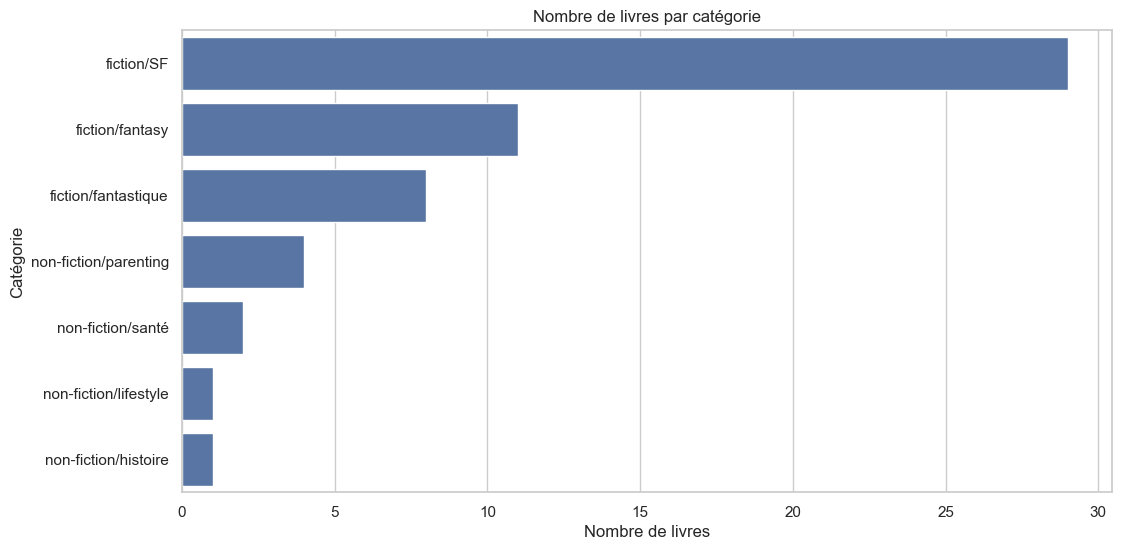

In [7]:
# plot avec seaborn en bar chhat le nombre de livre par categorie

#TODO 1 couleur par categorie principale "fiction" ou "non-fiction"


sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='Catégorie', data=df_book_streamlit, order=df_book_streamlit['Catégorie'].value_counts().index)
plt.title('Nombre de livres par catégorie')
plt.xlabel('Nombre de livres')
plt.ylabel('Catégorie')
plt.show()

In [28]:
# Calculer le nombre de livres par catégorie
category_counts = df_book_streamlit['Catégorie'].value_counts().reset_index()
category_counts.columns = ['Catégorie', 'nombre de livre']

# Créer un graphique à barres horizontal
fig = px.bar(category_counts,
             x='nombre de livre', 
             y='Catégorie',
             orientation='h',  # 'h' indique un bar chart horizontal
             title='Nombre de livres par catégorie',
             labels={'nombre de livre': 'Nombre de livres', 'Catégorie': 'Catégories'})

# Afficher le graphique
fig.show()

# visuel 2
heatmap heure de lecture et calendrier
https://plotly.com/python/heatmaps/
A retravailler mais on est pas loin

In [47]:
# Convertir la colonne 'date lecture' en datetime
df_stat['date lecture'] = pd.to_datetime(df_stat['date lecture'], format='%Y-%m-%d')

# Filtrer les données pour le mois d'octobre 2024
df_stat_octobre_2024 = df_stat[(df_stat['date lecture'].dt.year == 2024) & (df_stat['date lecture'].dt.month == 10)]

# Assurer que la colonne Heure est en forme entière si ce n'est pas le cas
if 'Heure' not in df_stat_octobre_2024.columns:
    df_stat_octobre_2024['Heure'] = df_stat_octobre_2024['heure de début'].apply(lambda x: pd.to_datetime(x).hour)

# Agréger le nombre de pages lues par jour et par heure
agg_data = df_stat_octobre_2024.groupby([df_stat_octobre_2024['date lecture'].dt.day, 'Heure'])['page'].sum().reset_index()

# Renommer les colonnes pour plus de clarté
agg_data.columns = ['Jour', 'Heure', 'Pages lues']

# Créer une table pivot pour la heatmap
pivot_table = agg_data.pivot(index='Heure', columns='Jour', values='Pages lues').fillna(0)

# Trier l'axe y de la heatmap du plus petit au plus grand
pivot_table = pivot_table.sort_index(ascending=True)

# Créer la heatmap avec Plotly
fig = px.imshow(pivot_table,
                labels=dict(x='Jour d\'octobre', y='Heure', color='Pages lues'),
                x=list(pivot_table.columns),
                y=list(pivot_table.index),
                color_continuous_scale='Viridis',
                title='Heatmap des pages lues par heure et par jour en octobre 2024',
                width=1200,  # Largeur de la heatmap
                height=800  # Hauteur de la heatmap
               )

# Personnalisation de l'apparence de la heatmap
fig.update_layout(
    xaxis_title='Jour d\'octobre',
    yaxis_title='Heure',
    title_x=0.5,
    font=dict(size=14),
    yaxis=dict(
        autorange="reversed"  # Inverser l'ordre des valeurs de l'axe y
    )
)

# Afficher la heatmap
fig.show()

# 3 score card
* plus longue lecture : heure de lecture max
* le plus régulier : jour de lecture = intervalle de lecture
* plus rapide : page lues à la minute
* plus addictif : pages lues par jour

## plus longue lecture

In [48]:
# le temps de lecture max
temps_maxi = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]

# prisme livre
titre_max_temps_lecture = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]["Titre"].values[0]
auteur_max_temps_lecture = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]["Auteurs"].values[0]
temps_max_lecture = df_book_streamlit["temps passé sur le livre en heure"].max()


print(f"Livre le plus long à lire : {titre_max_temps_lecture} de {auteur_max_temps_lecture} : {temps_max_lecture}")


Livre le plus long à lire : La Chute d'Hypérion: Le cycle d'Hypérion - Tome 2 de Dan Simmons : 13.3


## plus régulier
Trop de livre dans cette liste

In [50]:
# Afficher les livres ou la durée de lecture est égale à la durée de lecture effective
# df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]][["Titre", "Durée lecture (j)", "jours de lecture effectifs (jl)"]]

# Compter le nombre de lignes où "jours de lecture effectifs (jl)" est égal à "Durée lecture (j)"
count = df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].shape[0]

# affiche le dernier, puis l'avant dernier, puis l'avant avant dernier
df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].sort_values(by="Date de lecture", ascending
=False).head(3)[["Titre", "Durée lecture (j)", "jours de lecture effectifs (jl)", "Date de lecture"]]
# enregistre les 3 titres dans une liste
liste_livres = df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].sort_values(by="Date de lecture", ascending   =False).head(3)["Titre"].values


print(f"{count} livres lus tous les jours, les 3 derniers : {liste_livres}")


27 livres lus tous les jours, les 3 derniers : ["Projet secret T2 : Manuel de Survie du Sorcier Frugal dans l'Angleterre médiévale"
 'Voyageur 2 : Libration'
 "Blackwater 1 - La crue: L'épique saga de la famille Caskey"]


## le plus rapide
Utiliser le df non filtré

In [55]:
livre_rapide = df_book_updated[df_book_updated["temps passé sur le livre en minute"] > 35]
livre_rapide = livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]

titre_livre_rapide = livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["Titre"].values[0]
auteur_livre_rapide =livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["Auteurs"].values[0]
vitesse_livre_rapide =livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["pages lues à la minute"].values[0].round(1)


# titre_max_temps_lecture = df_book_streamlit[df_book_streamlit["Temps de lecture total (hh:mm:ss)"] == df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()]["Titre"].values[0]
# auteur_max_temps_lecture = df_book_streamlit[df_book_streamlit["Temps de lecture total (hh:mm:ss)"] == df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()]["Auteurs"].values[0]
# temps_max_lecture = df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()



print(f"Livre lu avec la vitessse max : {titre_livre_rapide} de {auteur_livre_rapide} à {vitesse_livre_rapide} pages à la minute")



Livre lu avec la vitessse max : la route de Cormac McCarthy à 2.0 pages à la minute


## plus addictif : max moyenne pages lues par jour

In [56]:
livre_addict = df_book_updated[df_book_updated["minutes_lecture_par_jour_de_lecture"] == df_book_updated["minutes_lecture_par_jour_de_lecture"].max()]
titre_livre_addict = livre_addict["Titre"].values[0]
auteur_livre_addict = livre_addict["Auteurs"].values[0]
minutes_livre_addict = livre_addict["minutes_lecture_par_jour_de_lecture"].values[0]

print(f"Livre lu avec la moyenne de temps de lecture par jour la plus élevée : {titre_livre_addict} de {auteur_livre_addict} avec {minutes_livre_addict} minutes de lecture par jour")

Livre lu avec la moyenne de temps de lecture par jour la plus élevée : la route de Cormac McCarthy avec 93.7 minutes de lecture par jour


## les stats depuis le prisme inversé : pic de vitesse (date et livre), page lu en 1 journée (date et livre), heure de lecture max en 1 journée (date et livre)

### 1. Heure de lecture max dans la journée

Partie 1 : group by date lecture
* probleme : 1 journée peut avoir jusqu'à 6 livres different. Donc impossible de retrouver les livres correspondant.

In [60]:
df_stat.head()

,id_book,page,heure de début,Temps passé sur la page en seconde,total_pages,id_long,Temps de lecture en minute,Temps de lecture en heure,date lecture,Heure de début de lecture,Heure,Heure en décimal,Jour Précédent,Est Consécutif,date de fin de lecture
0,1,1,2023-11-21 20:26:32,14,8,00001,0.233333,0.003889,2023-11-21,20:26:32,20,20.433333,2023-11-20,False,2023-11-21
1,1,6,2023-11-21 20:26:46,21,8,00001,0.350000,0.005833,2023-11-21,20:26:46,20,20.433333,2023-11-20,True,2023-11-21
2,1,7,2023-11-21 20:27:10,5,8,00001,0.083333,0.001389,2023-11-21,20:27:10,20,20.450000,2023-11-20,True,2023-11-21
3,1,8,2023-11-21 20:27:15,14,8,00001,0.233333,0.003889,2023-11-21,20:27:15,20,20.450000,2023-11-20,True,2023-11-21
4,2,5,2023-11-21 20:41:41,120,346,00002,2.000000,0.033333,2023-11-21,20:41:41,20,20.683333,2023-11-20,True,2023-11-27


In [ ]:
# groupby statlecture par date lecture, garder les colonnes : id_book, 
df_stat_grouped_date_1 = df_stat.groupby(['date lecture',"id_book"]).agg({ # probleme ici, avec le double group by, on perd les lignes sur le meme jour
    'Temps passé sur la page en seconde': 'sum',
    "page":"nunique"
}).reset_index()
df_stat_grouped_date_1["Temps passé sur la page en minute"] = (df_stat_grouped_date_1["Temps passé sur la page en seconde"] / 60).round(1)

df_stat_grouped_date_1.sort_values("Temps passé sur la page en minute", ascending=False).head(10)
# df_stat_grouped_date_1.sort_values("id_book", ascending=False).head(10)   

,date lecture,id_book,Temps passé sur la page en seconde,page,Temps passé sur la page en minute
271,2024-08-11,62,13500,257,225.0
187,2024-05-26,40,13206,385,220.1
265,2024-08-05,62,11729,220,195.5
302,2024-09-23,67,11293,271,188.2
341,2024-11-03,72,10506,237,175.1
176,2024-05-15,38,10180,278,169.7
89,2024-02-26,24,9616,227,160.3
242,2024-07-14,57,9500,226,158.3
88,2024-02-25,24,9493,235,158.2
307,2024-09-29,67,9136,266,152.3


partie 2 : group by date lecture + id book
* Fonctionne, mais on perd la notion de jours puisque une session de lecture sera divisée par ses differents livres.

In [58]:
df_stat_grouped_date_2 = df_stat.groupby(['date lecture', 'id_book']).agg({
    'Temps passé sur la page en seconde': 'sum',
    'page': 'nunique',
}).reset_index()

# Calcul du temps passé en minutes
df_stat_grouped_date_2["Temps passé à lire en minute"] = (df_stat_grouped_date_2["Temps passé sur la page en seconde"] / 60).round(1)



df_stat_grouped_date_2.sort_values("Temps passé à lire en minute", ascending=False).head(10)


,date lecture,id_book,Temps passé sur la page en seconde,page,Temps passé à lire en minute
271,2024-08-11,62,13500,257,225.0
187,2024-05-26,40,13206,385,220.1
265,2024-08-05,62,11729,220,195.5
302,2024-09-23,67,11293,271,188.2
341,2024-11-03,72,10506,237,175.1
176,2024-05-15,38,10180,278,169.7
89,2024-02-26,24,9616,227,160.3
242,2024-07-14,57,9500,226,158.3
88,2024-02-25,24,9493,235,158.2
307,2024-09-29,67,9136,266,152.3


In [65]:
df_book_updated.head()

,id,Titre,Auteurs,Auteurs courts,Langue,categorie,série,numéro_série,oeuvre,First published date,Date dernière ouverture,total Nbr de pages du livre,total Nbr de pages lues,pages lues à la minute,pourcent_lu,start_date,end_date,intervalle_lecture_en_jour,nb_dates_lecture_distinctes,nb_pages_lues_par_jour_de_lecture,temps passé sur le livre en seconde,temps passé sur le livre en minute,temps passé sur le livre en heure,heure_lecture_par_jour_de_lecture,minutes_lecture_par_jour_de_lecture,temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss),total_temps_de_lecture_(hh:mm:ss)
0,73,Projet secret T2 : Manuel de Survie du Sorcier...,Brandon Sanderson,Brandon Sanderson,fr,fiction/fantasy,N/A,None,Projet secret T2 : Manuel de Survie du Sorcier...,2023,2024-11-06,636,114,1.665449,18,2024-11-04,2024-11-06,3,3,38.0,4107,68.45,1.14,0.38,22.8,0:22,1:08:27
1,72,Voyageur 4 : La Galaxie vue du sol,Becky Chambers,Becky Chambers,fr,fiction/SF,Les voyageurs,4,Voyageur 4 : La Galaxie vue du sol - Becky Cha...,2021,2024-11-04,400,382,1.299452,100,2024-10-27,2024-11-04,9,6,63.7,17638,293.97,4.90,0.82,49.0,0:49,4:53:58
2,71,Blackwater 4 – La Guerre: L'épique saga de la ...,Michael McDowell,Michael McDowell,fr,fiction/fantastique,Blackwater,4,Blackwater 4 – La Guerre: L'épique saga de la ...,1983,2024-11-02,257,249,1.741624,100,2024-10-23,2024-11-02,11,6,41.5,8578,142.97,2.38,0.40,23.8,0:24,2:22:58
3,70,Voyageur 3 : Archives de l'exode,Becky Chambers,Becky Chambers,fr,fiction/SF,Les voyageurs,3,Voyageur 3 : Archives de l'exode - Becky Chambers,2018,2024-10-23,441,422,1.137773,100,2024-10-08,2024-10-23,16,13,32.5,22254,370.90,6.18,0.48,28.5,0:28,6:10:54
4,69,Blackwater 3 – La Maison: L'épique saga de la ...,Michael McDowell,Michael McDowell,fr,fiction/fantastique,Blackwater,3,Blackwater 3 – La Maison: L'épique saga de la ...,1983,2024-10-08,213,206,1.441870,100,2024-10-03,2024-10-08,6,5,41.2,8572,142.87,2.38,0.48,28.6,0:28,2:22:52


Solution : 

Faire un group by, date lecture : 
* sum : temps passé sur la page
* sum id_book
* concatenate la liste des id_book de chaque ligne ? (ou les titres de livre directement)


--> Permet d'identifier le jour avec le plus longtemps en lecture, et les livres identifiés

In [66]:
# Convertir la colonne 'date lecture' en datetime
df_stat['date lecture'] = pd.to_datetime(df_stat['date lecture'], format='%Y-%m-%d')

# Joindre df_stat avec df_book_updated pour inclure le nom des livres
df_stat = df_stat.merge(df_book_updated, left_on='id_book', right_on='id', how='left')

# Agréger les données par 'date lecture'
agg_data = df_stat.groupby('date lecture').agg({
    'Temps de lecture en minute': 'sum',
    'page': 'nunique',
    'id_book': 'nunique'
}).reset_index()

# Ajouter la liste des id_book et des titres pour chaque date de lecture
book_ids_titles_by_date = df_stat.groupby('date lecture').apply(
    lambda x: ', '.join(sorted(set(f"{row['id_book']} ({row['Titre']})" for _, row in x.iterrows())))
).reset_index()

# Fusionner les deux DataFrames
merged_data = pd.merge(agg_data, book_ids_titles_by_date, on='date lecture')

# Renommer pour plus de clarté
merged_data.columns = ['date lecture', 'Temps de lecture en minute', 'Nombre de pages', 'Nombre de livres', 'Books']

# Afficher le résultat
print(merged_data)

    date lecture  Temps de lecture en minute  Nombre de pages  \
0     2012-05-01                   36.900000               52   
1     2023-11-21                   33.833333               40   
2     2023-11-22                   21.166667               36   
3     2023-11-23                   91.300000              160   
4     2023-11-24                    9.500000               11   
..           ...                         ...              ...   
265   2024-11-02                   69.783333               92   
266   2024-11-03                  175.100000              237   
267   2024-11-04                   36.633333               69   
268   2024-11-05                   22.150000               31   
269   2024-11-06                    9.816667               15   

     Nombre de livres                                              Books  
0                   2  57 (Légendes et lattes), 58 (Roman secret 3 - ...  
1                   2          1 (nan), 2 (Le crime de l'Orient-Expre

C:\Users\chric\AppData\Local\Temp\ipykernel_21332\4005772689.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [67]:
# print les 10 premières lignes, triées par 'Temps de lecture en minute' de manière décroissante
merged_data.sort_values('Temps de lecture en minute', ascending=False).head(10)



,date lecture,Temps de lecture en minute,Nombre de pages,Nombre de livres,Books
238,2024-09-29,294.883333,428,2,"67 (Voyageur 1 : L'Espace d'un an), 68 (Voyage..."
206,2024-08-11,231.566667,267,2,"62 (Leviathan Wakes - the expanse 1), 63 (Blac..."
142,2024-05-26,220.100000,385,1,40 (Des fleurs pour Algernon)
209,2024-08-14,195.566667,233,2,63 (Blackwater 1 - La crue: L'épique saga de l...
201,2024-08-05,195.483333,220,1,62 (Leviathan Wakes - the expanse 1)
233,2024-09-23,188.216667,271,1,67 (Voyageur 1 : L'Espace d'un an)
132,2024-05-15,178.200000,290,2,38 (Trois corps – 01 – Le problème à trois cor...
266,2024-11-03,175.100000,237,1,72 (Voyageur 4 : La Galaxie vue du sol)
59,2024-02-25,169.483333,235,2,"19 (Il n'y a pas de parent parfait), 24 (Red R..."
60,2024-02-26,160.266667,227,1,24 (Red Rising)


### Pic de vitesse : 